**Autor** : Jeferson Magalhães dos Santos

**e-mail**: jefersonmdossantos@gmail.com

**github**: jefersonmglh

#  <a name="indice">  Índice </a>

* [Resumo](#resumo)
* [1. Importação de pacotes](#1)
* [2. Carregamento de dados e preparação](#2)
  * [2.1 Descrição das features](#2.1)
  * [2.2 Análise preliminar](#2.2)
  * [2.3 Engeharia das Features](#2.3)
* [3. Análise exploratória](#3)
  * [3.1 Overview](#3.1)
  * [3.2 Distribuições](#3.2)
  * [3.3 Correlação e Associação](#3.3)
* [4. Modelagem](#4)
  * [4.1 Pré-processamento](#4.1)
  * [4.2 Aplicações](#4.2)
* [5. Avaliação](#5)
* [6. Aprimoramento do modelo](#6)
* [7. Referências](#7)

#  <a name="resumo"> RESUMO </a>
[Voltar ao índice](#indice)

<p> Análise exploratória e inferições com relação aos dados de preço de aluguel de propriendades de Sâo Paulo

#  <a name="1">1. Importação de pacotes e dados </a>
[Voltar ao índice](#indice)

In [64]:
#basic
import pandas as pd
import numpy as np
np.random.seed(0)
pd.set_option('display.max_columns', None)

#graph
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#model&metrics
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import chi2, chi2_contingency, iqr, pearsonr
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')


> EDA
>> UniVar (distritos que mais aparecem; area média; tipos que mais aparecem; distr quanti)

>> BiVar (distritos com mais área; endereços mais caros? ; tipos mais caros; area x total ; distritos com maior taxa;


#  <a name="2">2. Carregamento de dados e preparação</a>
[Voltar ao índice](#indice)

In [65]:
df = pd.read_csv('/content/data.csv')
df.head()

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654


> ####  <a name="2.1">2.1 Descrição das features</a>
[Voltar ao índice](#indice)

* Address: Endereço da propriedade
* District: Distrito onde está localizado
* Area: Área em m² da propriedade
* Bedrooms: Número de banheiros
* Garage: Número de garagens disponíveis
* Rent: Preço do Aluguel
* Type: Tipo da propriedade
* Total: O preço total da propriedade, incluindo aluguel e taxas.

> ####  <a name="2.2">2.2 Análise preliminar</a>
[Voltar ao índice](#indice)

In [66]:
def show_info(data):
    print('DATASET SHAPE: ', data.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(data.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(data.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(data.isnull().sum())


In [67]:
print('TRAIN SET INFO')
show_info(df)

TRAIN SET INFO
DATASET SHAPE:  (11657, 8) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

address     5348
district    1199
area         381
bedrooms       7
garage         7
type           4
rent        1662
total       5571
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
address     0
district

In [68]:
print('QUANT INFO')

df.describe()

QUANT INFO


,area,bedrooms,garage,rent,total
count,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000
mean,84.655658,1.966286,1.060393,3250.814789,4080.030625
std,74.020536,0.931313,1.132349,2650.711557,3352.480274
min,0.000000,0.000000,0.000000,500.000000,509.000000
25%,40.000000,1.000000,0.000000,1590.000000,1996.000000
50%,60.000000,2.000000,1.000000,2415.000000,3057.000000
75%,96.000000,3.000000,2.000000,3800.000000,4774.000000
max,580.000000,6.000000,6.000000,25000.000000,28700.000000


NULL VALUES


<Axes: >

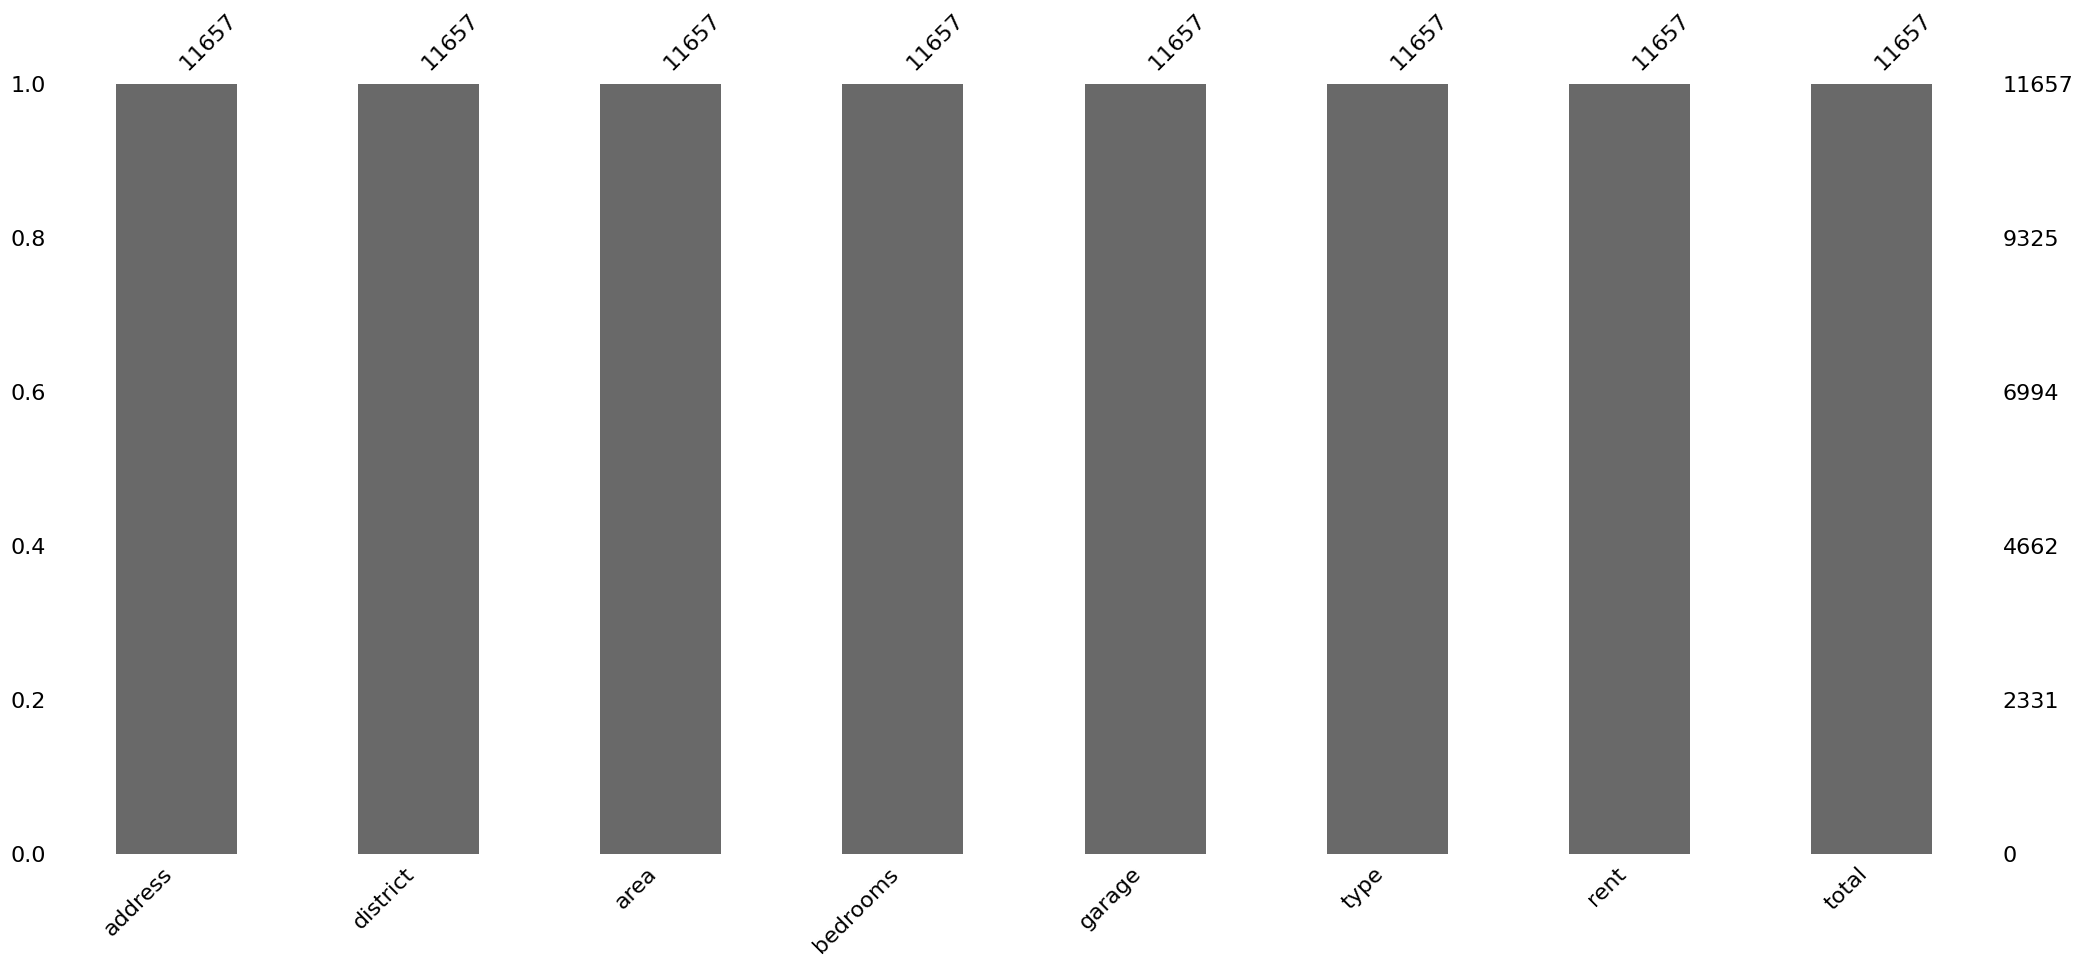

In [69]:
print('NULL VALUES')
msno.bar(df)

Afirmações:


* O DataSet não apresenta nenhum valor nulo ou faltante.

* Em média, uma propriedade em SP apresenta uma área de ~85m², com no máximo 2 quartos, 1 garagem e preço médio de R$ 3250.

* O maior valor total de aluguel encontrado neste DataSet é de R$ 25000.

> ####  <a name="2.3">2.3 Engenharia das features</a>
[Voltar ao índice](#indice)

* criação de duas novas variáveis:
  * 'garage_bin': com valores binários. indica se há ou não garagem na propriedade
  * 'fees': valor das taxas incluso no valor total do aluguel.

In [70]:
df['fees'] = df['total'] - df['rent']
df.rename(columns={'garage': 'garage_num'}, inplace=True)
df['garage_bin'] =df['garage_num'].apply(lambda x: 1 if x > 0 else 0)
df

,address,district,area,bedrooms,garage_num,type,rent,total,fees,garage_bin
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939,539,0
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345,315,1
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661,661,0
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954,204,1
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654,654,0
...,...,...,...,...,...,...,...,...,...,...
11652,Avenida Adolfo Pinheiro,Santo Amaro,94,2,1,Apartamento,4100,5778,1678,1
11653,Rua Professor Alexandre Correia,Jardim Vitória Régia,350,4,4,Apartamento,11250,17480,6230,1
11654,Rua Abílio Borin,Jardim Caravelas,84,1,2,Apartamento,4500,5467,967,1
11655,Rua Forte William,Jardim Fonte do Morumbi,76,1,0,Apartamento,9000,10200,1200,0


#  <a name="3">3. Análise Exploratória</a>
[Voltar ao índice](#indice)

> ####  <a name="3.1">3.1 Overview</a>
[Voltar ao índice](#indice)

In [71]:
show_info(df)

DATASET SHAPE:  (11657, 10) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   address     11657 non-null  object
 1   district    11657 non-null  object
 2   area        11657 non-null  int64 
 3   bedrooms    11657 non-null  int64 
 4   garage_num  11657 non-null  int64 
 5   type        11657 non-null  object
 6   rent        11657 non-null  int64 
 7   total       11657 non-null  int64 
 8   fees        11657 non-null  int64 
 9   garage_bin  11657 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 910.8+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

address       5348
district      1199
area           381
bedrooms         7
garage_num       7
type             4
rent          1662
total         5571
fees     

Vamos traduzir o nome das colunas para melhor visualização:

In [72]:
translate_ = {
    'address': 'Endereço',
    'district': 'Distrito',
    'area': 'Area',
    'bedrooms': 'Num_Quartos',
    'garage_num': 'Num_Garagens',
    'type': 'Tipo',
    'rent': 'Aluguel',
    'total': 'Total_Aluguel',
    'fees': 'Taxa'
}


df.rename(columns=translate_, inplace=True)

In [73]:
target = 'Total_Aluguel'
quanti_columns = ['Area', 'Num_Quartos', 'Num_Garagens', 'Aluguel', 'Total_Aluguel', 'Taxa']
quali_columns = [x for x in df.columns if x not in quanti_columns and x not in target[0]]
features = quanti_columns + quali_columns

features.remove(target)


> ####  <a name="3.2">3.2 Distribuições</a>
[Voltar ao índice](#indice)

* UniVar


DISTRIBUIÇÕES VARIÁVEIS QUALITATIVAS
Endereço


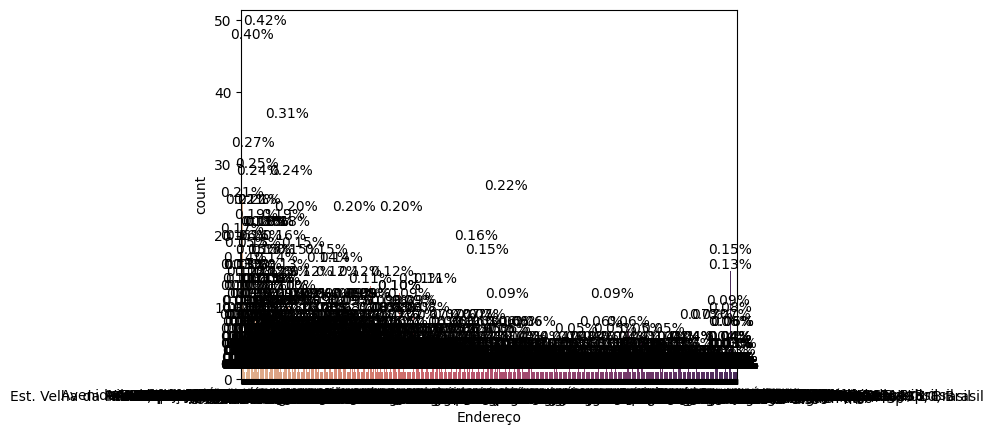

Distrito


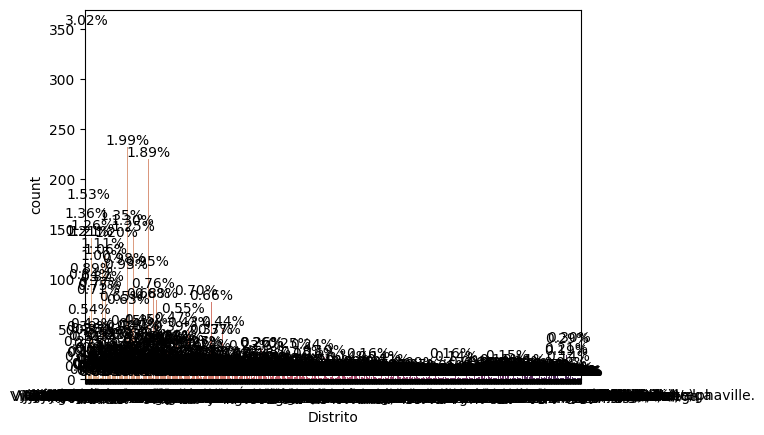

Tipo


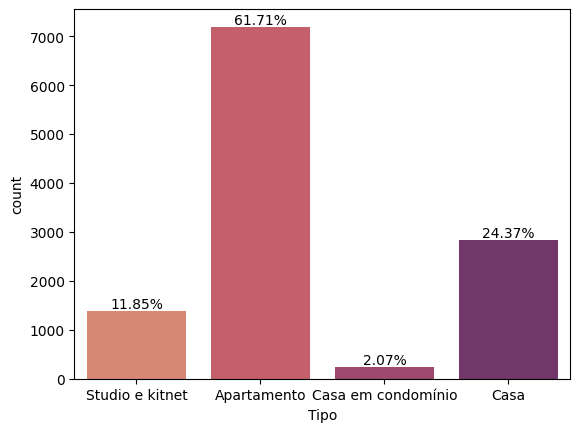

garage_bin


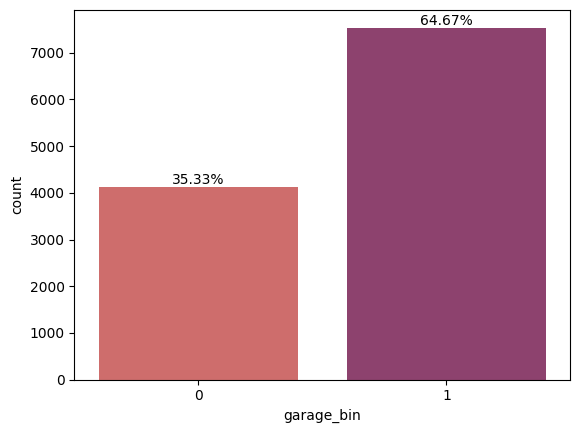

In [74]:
print('DISTRIBUIÇÕES VARIÁVEIS QUALITATIVAS')
for var_quali in quali_columns:
    print(var_quali)
    fig, ax = plt.subplots()
    sns.countplot(x=df[var_quali], palette='flare', ax=ax)
    total = float(len(df[var_quali]))
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
    plt.show()


  * Mais da metade das propriedades são do tipo 'Apartamento'. Assim como, propriedades que tenham garagem. O tipo 'Casa' corresponde a 1/4 do total.
  * Como há muitos valores únicos em 'address' e 'district', a visualização gráfica da distribuição destas variáveis ficou prejudicada. Um novo método foi realizado a seguir:

DISTRIBUIÇÕES VARIÁVEIS QUANTITATIVAS


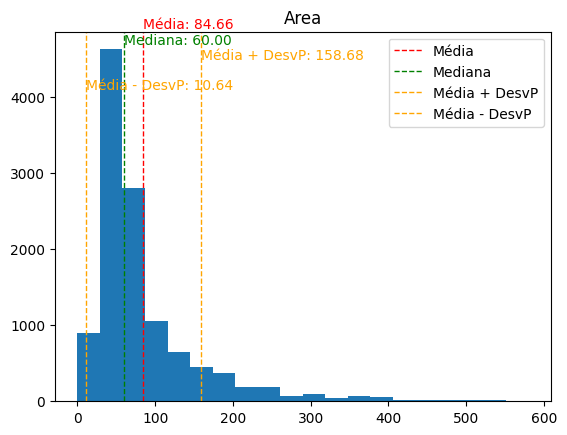

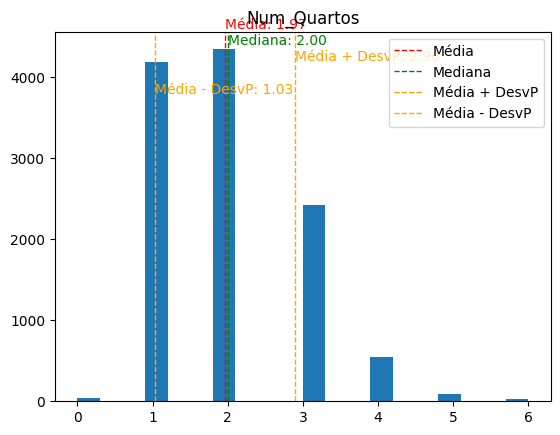

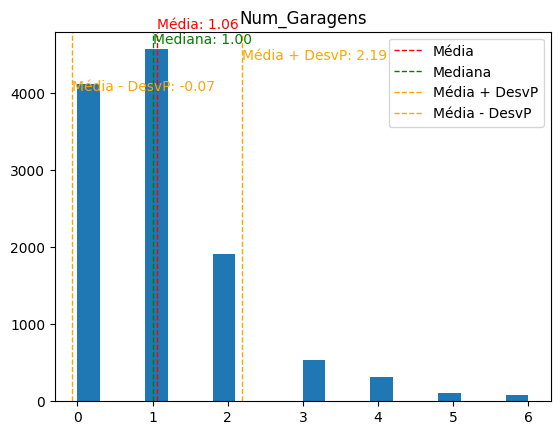

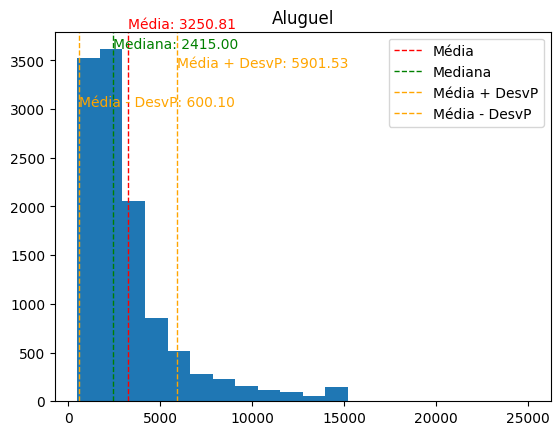

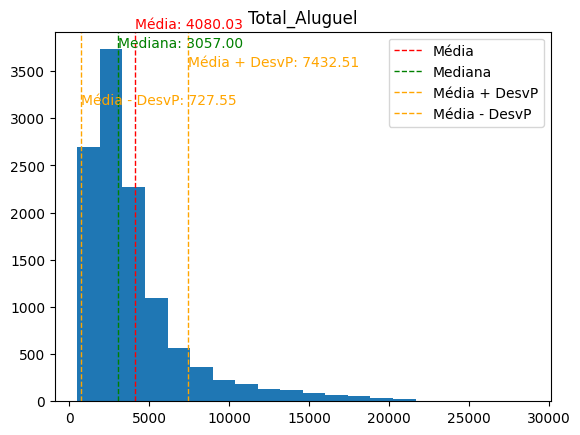

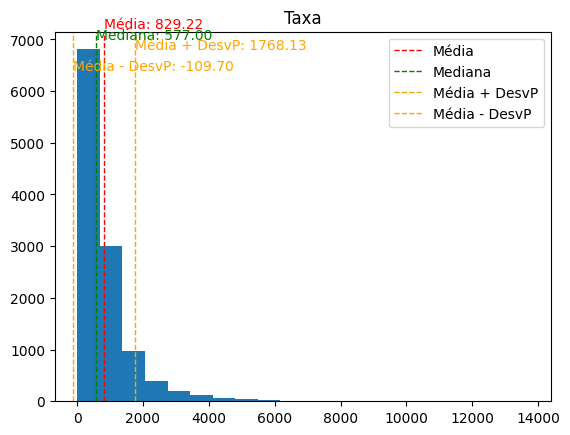

In [75]:

print('DISTRIBUIÇÕES VARIÁVEIS QUANTITATIVAS')
for var_quanti in quanti_columns:
    plt.hist(df[var_quanti], bins=20)

    mean = df[var_quanti].mean()
    median = df[var_quanti].median()
    std = df[var_quanti].std()

    plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Média')
    plt.axvline(median, color='green', linestyle='dashed', linewidth=1, label='Mediana')
    plt.axvline(mean + std, color='orange', linestyle='dashed', linewidth=1, label='Média + DesvP')
    plt.axvline(mean - std, color='orange', linestyle='dashed', linewidth=1, label='Média - DesvP')

    plt.text(mean, plt.ylim()[1], f'Média: {mean:.2f}', color='red', va='bottom')
    plt.text(median, plt.ylim()[1]-200, f'Mediana: {median:.2f}', color='green', va='bottom')
    plt.text(mean + std, plt.ylim()[1]-400, f'Média + DesvP: {mean + std:.2f}', color='orange', va='bottom')
    plt.text(mean - std, plt.ylim()[1]-800, f'Média - DesvP: {mean - std:.2f}', color='orange', va='bottom')

    plt.title(var_quanti)
    plt.legend()
    plt.show()

  * Aluguel, área e taxas apresentam uma distribuição assimétrica a esquerda, o que nos leva a afirmar um maior volume de dados com baixa área e, consequentemente, menor valor de aluguel (considerando assim uma correlação positiva entre essas duas variáveis)
  * A área média das propriedades é em torno de 85m²
  * O valor total de aluguel médio giram em torno de R$4000

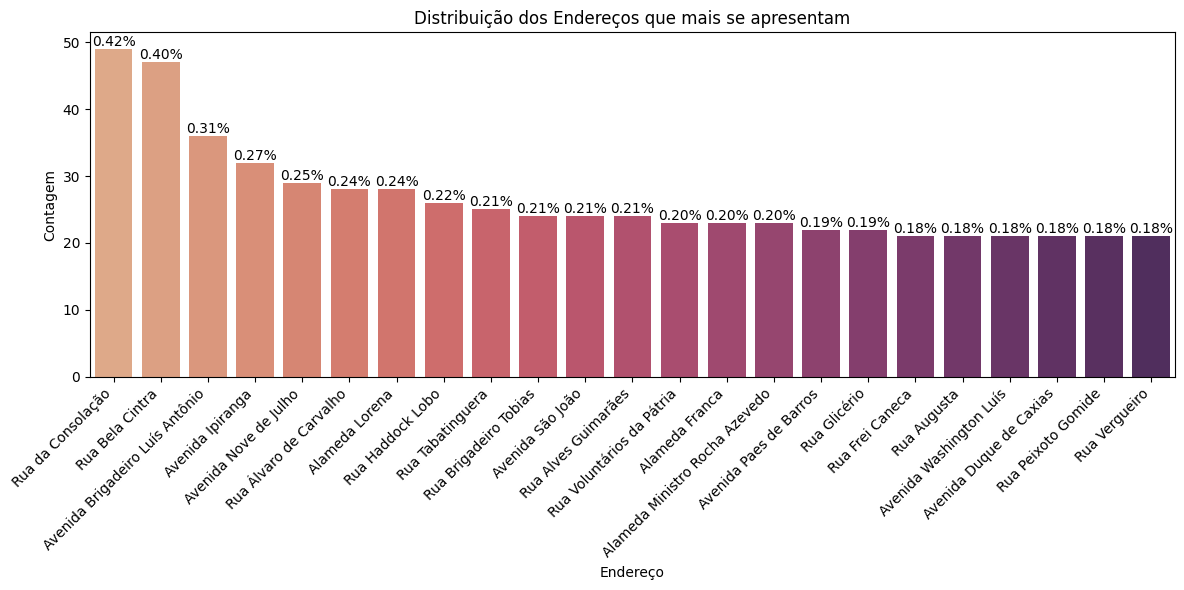

In [76]:
df_address = df.groupby('Endereço')['Tipo'].count().sort_values(ascending=False)
df_address = df_address[df_address>20]


fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=df_address.index, y=df_address, palette='flare')
plt.xticks(rotation=45, ha = 'right')
plt.ylabel('count')

total = len(df['Endereço'])

for p in ax.patches:
    height = p.get_height()

    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
plt.xlabel('Endereço')
plt.ylabel('Contagem')
plt.title('Distribuição dos Endereços que mais se apresentam')


plt.tight_layout()
plt.show()

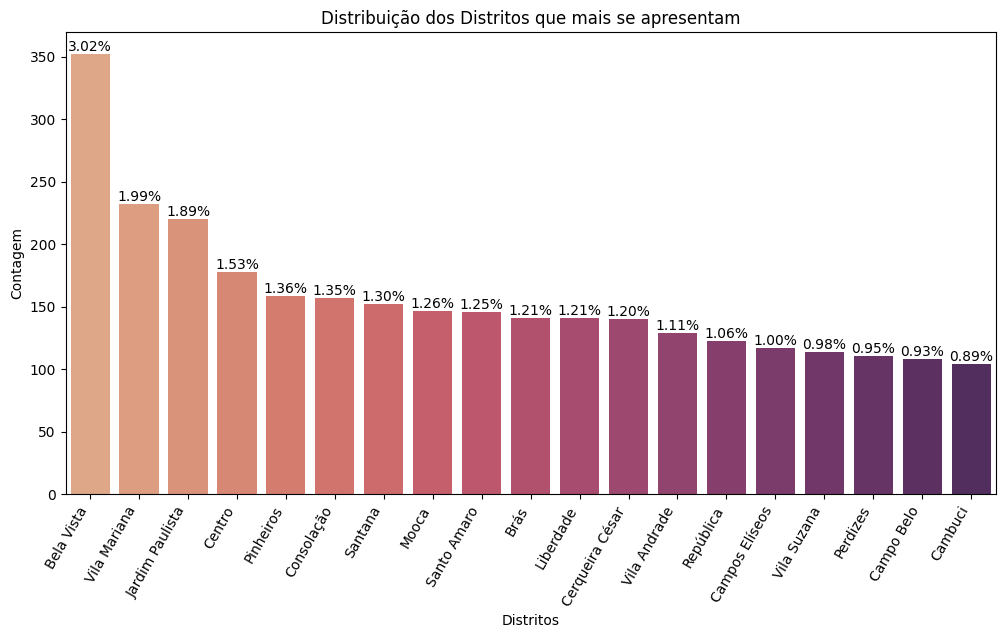

In [77]:
df_district = df.groupby('Distrito')['Endereço'].count().sort_values(ascending=False)
df_district = df_district[df_district>100]

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=df_district.index, y=df_district, palette='flare')
plt.xticks(rotation=60, ha='right')

total = len(df['Distrito'])

for p in ax.patches:
    height = p.get_height()

    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.xlabel('Distritos')
plt.ylabel('Contagem')
plt.title('Distribuição dos Distritos que mais se apresentam')


plt.show()

  * Para termos melhor visualização das distritos e endereços fizemos um gráfico destes que mais se aparecem em nosso dataset.
  * E, obviamente, os endereços que mais se apresentaram são ruas e avenidas famosas na cidade. eg.: Avenida Brigadeiro Luis Antonio, Rua Bela Cintra, Rua da Consolação, etc.
  * Consequentemente, os distritos que mais se sobresaem são os da regiões centrais como Bela Vista, Jardim Paulista e Centro; Assim como alguns outros da região Oeste, como: Vila Mariana e Pinheiros.

* BiVar


Aqui iremos iniciar a análise bivariada. Iremos considerar duas variáveis como 'target': Primeiro uma análise com todas as variáveis com Total_Aluguel e, posteriormente, uma análise sobre as Taxas em cada Distrito e Tipo.

Tipo


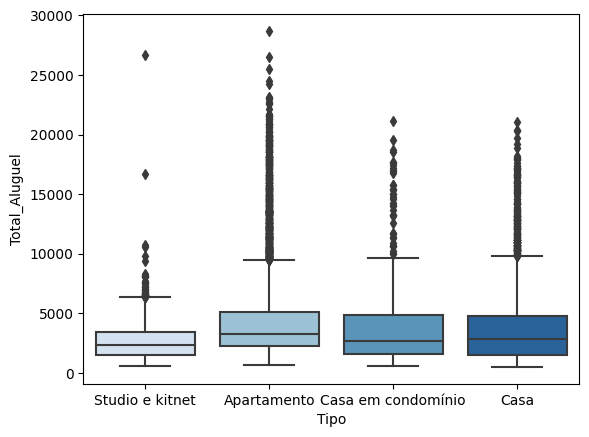

garage_bin


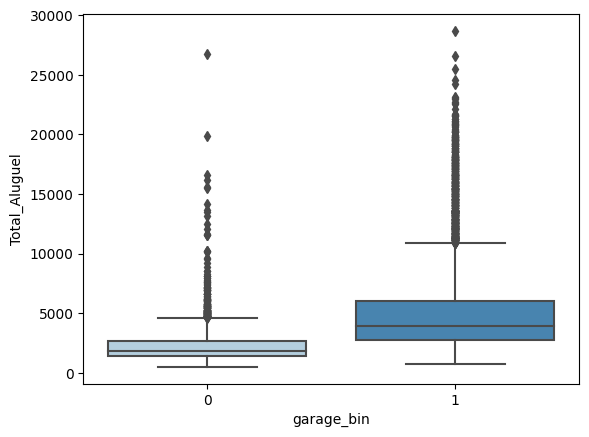

In [78]:
for var_quali in quali_columns:
  if var_quali not in ['Endereço', 'Distrito']:
    print(var_quali)

    sns.boxplot(x=df[var_quali].astype('str'), y='Total_Aluguel', data=df, palette='Blues')
    plt.show()

  * Comparando os tipos de propriedades com o valor total de aluguel, observamos que Apartamentos são os mais caros, enquanto que Studios e Kitnets são os mais em conta.
  * Obviamente, se há garagem na propriedade o valor de aluguel irá ser maior.

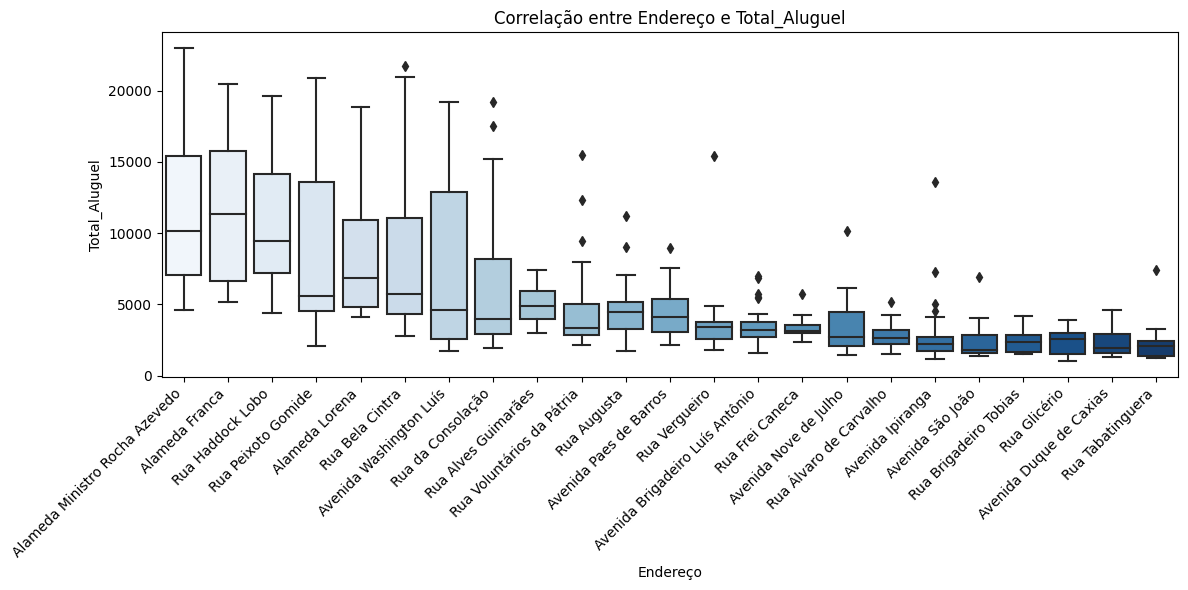

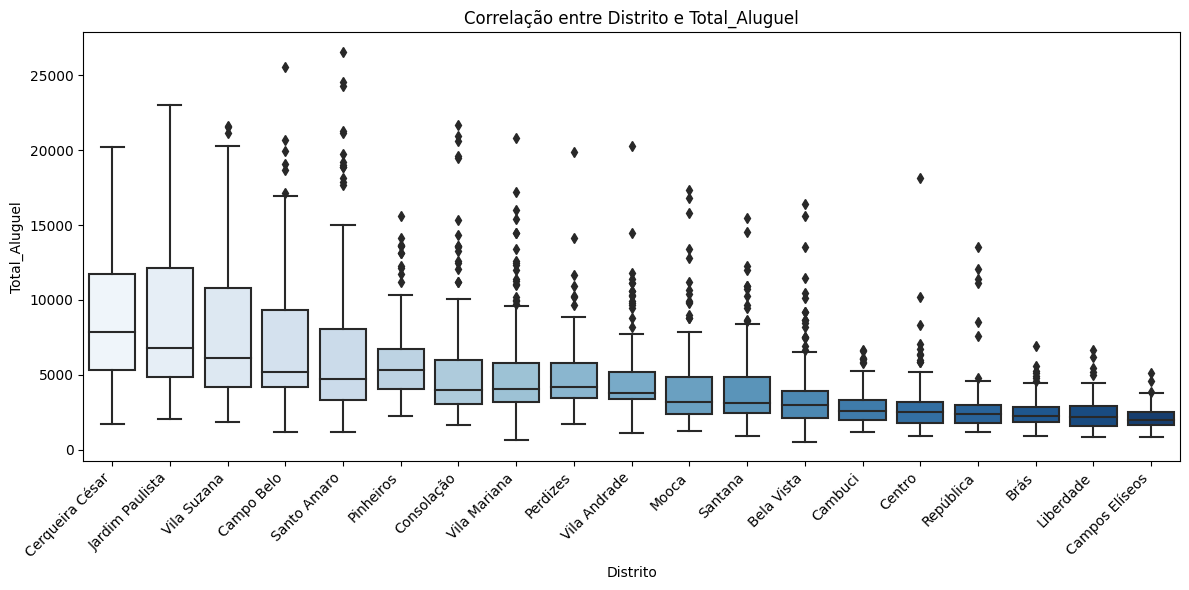

In [79]:
for var, df_grouped in {'Endereço': df_address, 'Distrito': df_district}.items():
  x = df[df[var].isin(df_grouped.index)]
  mean = x.groupby(var)['Total_Aluguel'].mean().sort_values(ascending=False)

  fig, ax = plt.subplots(figsize=(12,6))
  sns.boxplot(x=var, y='Total_Aluguel', data=x, palette='Blues', order=mean.index, ax=ax)
  plt.xticks(rotation=45, ha='right')
  plt.title(f'Correlação entre {var} e Total_Aluguel')
  plt.tight_layout()
  plt.show()

* Acima, temos a distribuição comparando os Endereços / Distritos que mais aparece e ordenamos com a média Total_Aluguel entre eles. Observamos que a região central e oeste são as que mais se destacam.

* Abaixo temos os endereços e distritos que com a maior média Total_Aluguel. O que temos que analisar aqui que essa distribuição e ordem podem estar sendo interferidas por 'outliers', ou seja, alguma excessão em determinado Endereço/Distrito que seja muito alto.


In [80]:
df_district = df.groupby('Distrito')['Total_Aluguel'].mean().sort_values(ascending=False)
df_district = df_district.iloc[:20]

df_address = df.groupby('Endereço')['Total_Aluguel'].mean().sort_values(ascending=False)
df_address = df_address.iloc[:10]


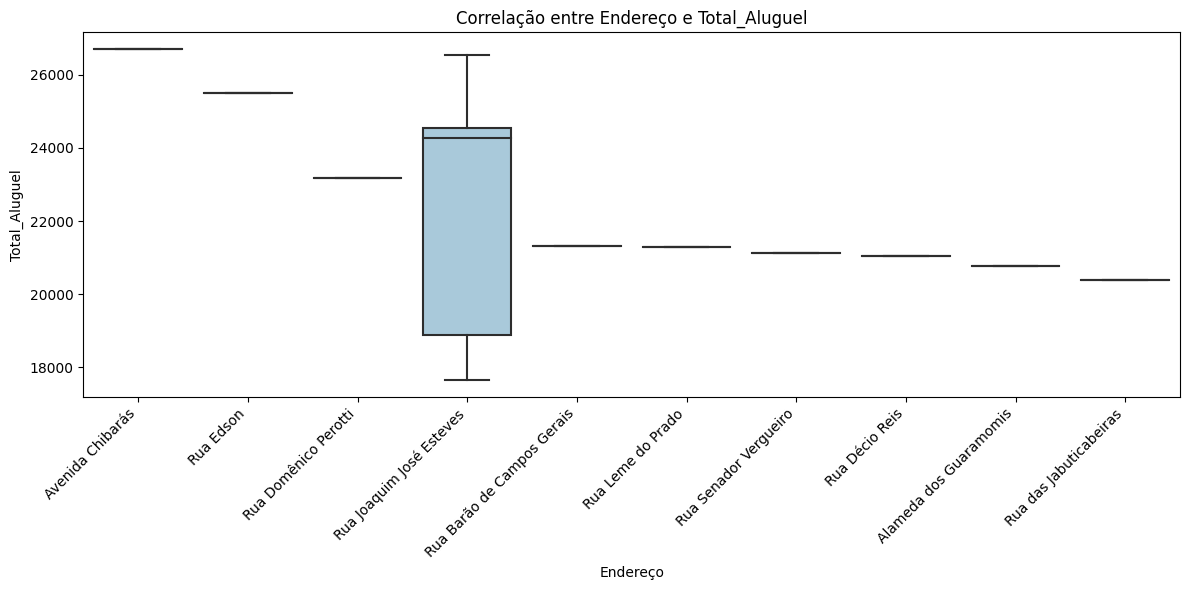

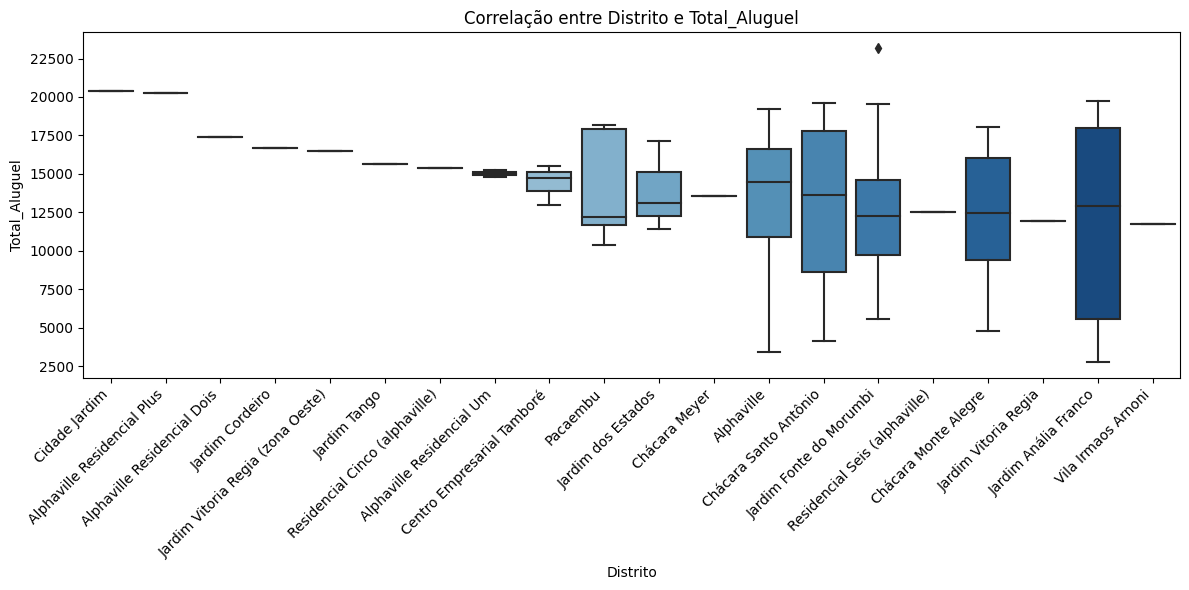

In [81]:
for var, df_grouped in {'Endereço': df_address, 'Distrito': df_district}.items():
  x = df[df[var].isin(df_grouped.index)]
  mean = x.groupby(var)['Total_Aluguel'].mean().sort_values(ascending=False)

  fig, ax = plt.subplots(figsize=(12,6))
  sns.boxplot(x=var, y='Total_Aluguel', data=x, palette='Blues', order=mean.index, ax=ax)
  plt.xticks(rotation=45, ha='right')
  plt.title(f'Correlação entre {var} e Total_Aluguel')
  plt.tight_layout()
  plt.show()

* Mesmo assim, é possível notar a presença de alguns bairros conhecidos como Alphaville, Morumbi, entre outros. Notamos também que, mesmo estes bairros sendo conhecidos por serem nobres, neste dataset, temos poucos dados de propriedades.

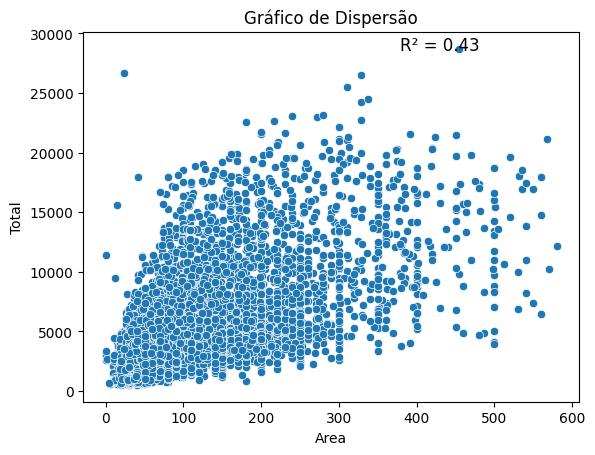

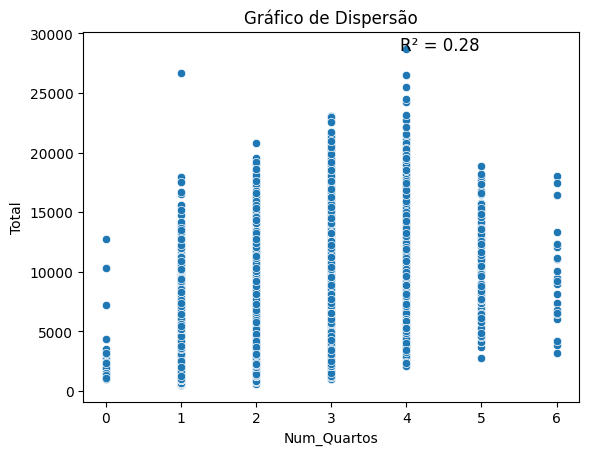

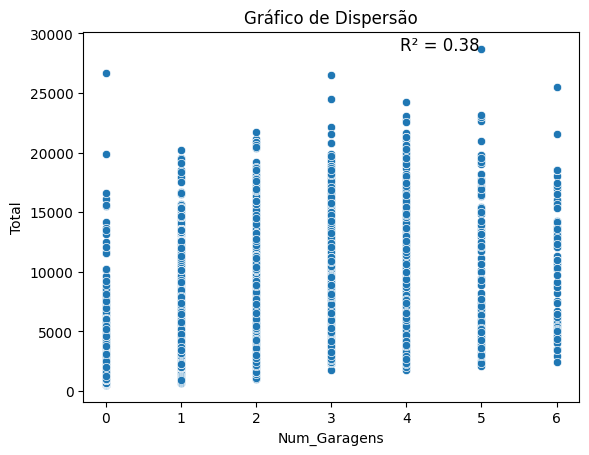

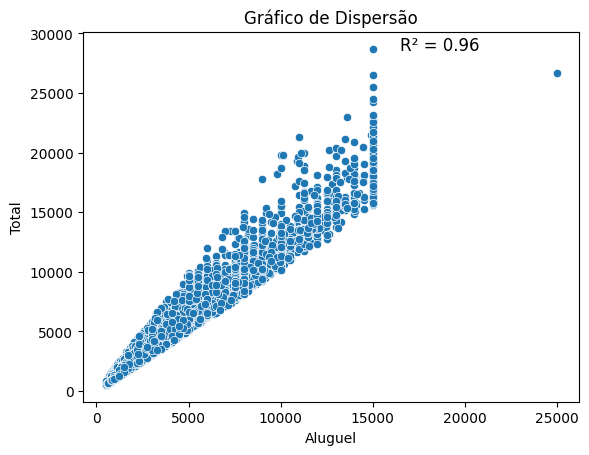

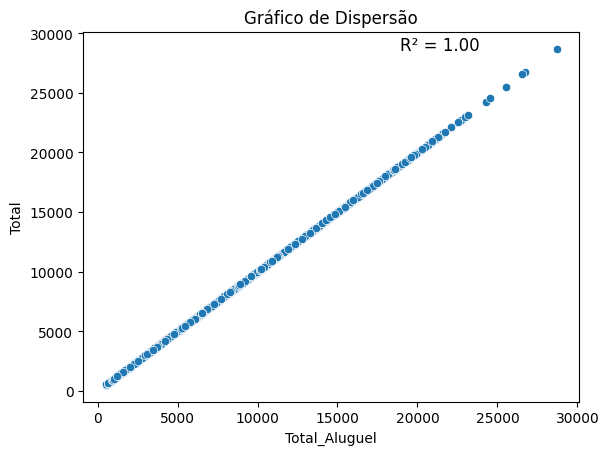

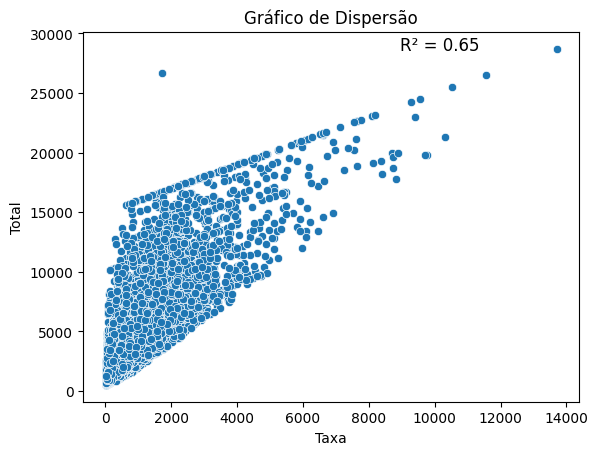

In [82]:
for var_quanti in quanti_columns:
  sns.scatterplot(x=var_quanti, y='Total_Aluguel', data=df)
  corr = df[var_quanti].corr(df['Total_Aluguel'])
  r_squared = corr**2

  plt.annotate(f"R² = {r_squared:.2f}", xy=(0.8, 0.95), xycoords='axes fraction', fontsize=12, ha='right')

  plt.title('Gráfico de Dispersão')
  plt.xlabel(var_quanti)
  plt.ylabel('Total')

  plt.show()

* Observamos a correlação entre algumas variáveis numéricas e o valor Total de Aluguel.
* Como previsto, uma correlação positiva entre Área e Aluguel.
* Como também é lógico, uma relação bastante linear entre Total_Aluguel , taxas e Aluguel, sendo uma função da outra.
* Como o número de quartos e garagens são variáveis discretas é mais interessante uma visualização a partir de BoxPlots:

Num_Quartos


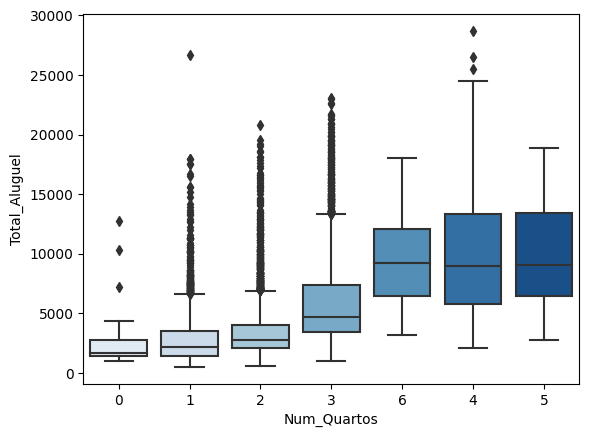

Num_Garagens


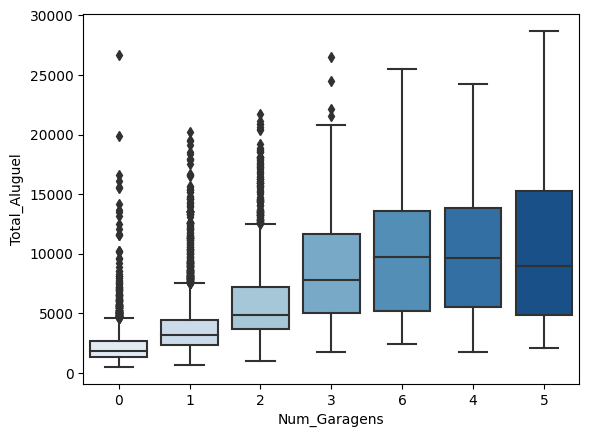

In [83]:
for var in ['Num_Quartos', 'Num_Garagens']:
    print(var)
    order = df.groupby(var)['Total_Aluguel'].mean().sort_values()
    sns.boxplot(x=df[var].astype('str'), y='Total_Aluguel', data=df, palette='Blues', order=order.index.astype('str'))
    plt.show()

* Observamos que até 3 Garagens e Quartos a média de Aluguel aumenta consideravalmente. Porém, esse aumento não é visto a partir de 4 quartos ou garagens, sendo a média muito parecida entre eles.

> ####  <a name="3.3">3.3 Correlação e associação</a>
[Voltar ao índice](#indice)

<Axes: title={'center': 'Correlação entre as variáveis'}>

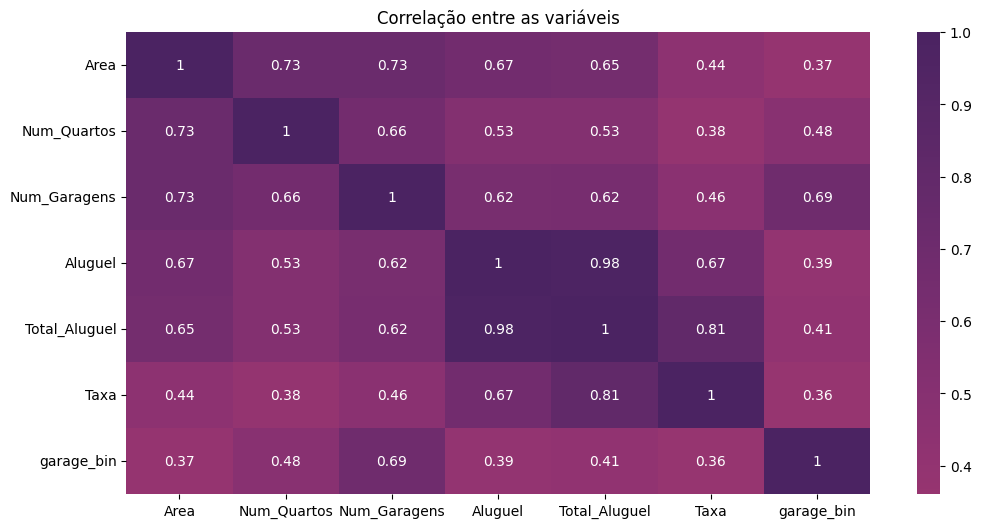

In [84]:
plt.figure(figsize=(12,6))
plt.title('Correlação entre as variáveis')
sns.heatmap(df.corr(),cmap='flare', center=0, annot=True)

#  <a name="4">4. Modelagem</a>
[Voltar ao índice](#indice)

> ####  <a name="4.1">4.1 Pré-processamento</a>
[Voltar ao índice](#indice)

> ####  <a name="4.2">4.2 Aplicações</a>
[Voltar ao índice](#indice)

#  <a name="5">5. Avaliação</a>
[Voltar ao índice](#indice)

#  <a name="6">6. Aprimoramento do modelo</a>
[Voltar ao índice](#indice)

#  <a name="7">7. Referências</a>
[Voltar ao índice](#indice)

* https://www.kaggle.com/datasets/renatosn/sao-paulo-housing-prices